# **Computer Vision Assignment-1**

In [185]:
# Libraries
import numpy as np
import cv2
import warnings
import math
import glob
import matplotlib.pyplot as plt
from random import randint

## **1. Direct Linear Transform**

**1.1** For the given image calib-object.jpg , use any 20-30 different points on different planes and perform the Direct Linear Transform (DLT) based calibration as discussed in class. Note that you need to manually estimate the image co-ordinates of the given world points and refer to calib-object-legend.jpg for world measurements.

Assume these two scales :

(a) Scale of each chessblock = 28x28mm

(b) Scale of each chessblock = 2800x2800mm

Perform these three experiments, report the projection matrix and reconstruction error, for both the above mentioned scales:

**1.1 (a)** Use original data points as input.

Perform reconstruction on the original data points. (main experiment)

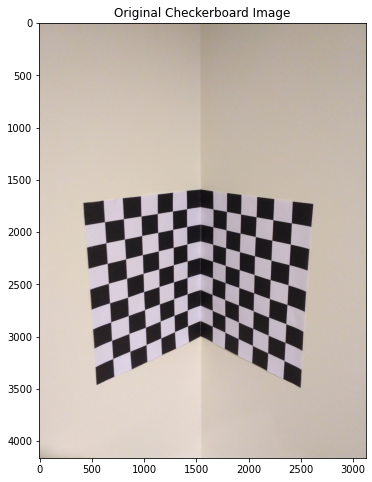

In [186]:
# Plotting the chessboard
cb = cv2.imread('../calibration-data/calib-object.jpg', cv2.IMREAD_COLOR)
# Converting BGR to RGB
cb = cv2.cvtColor(cb, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (6, 8))
plt.title("Original Checkerboard Image")
plt.imshow(cb)
plt.show()

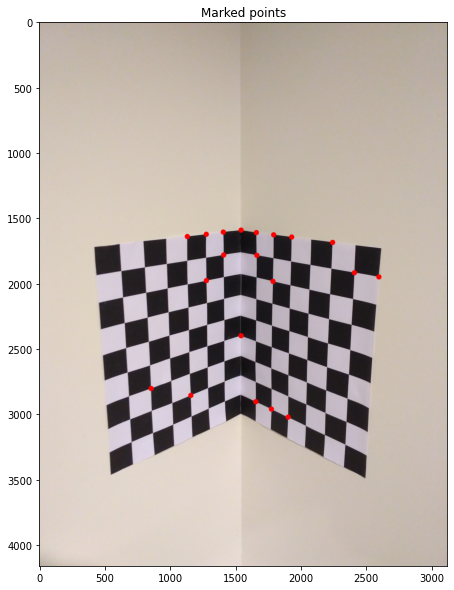

In [187]:
# Coordinates
worldCoords = [[168, 28, 0], [0, 0, 0], [56, 56, 0], [140, 0, 0], [0, 28, 28], [0, 56, 56], [56, 0, 0], [0, 0, 56], [28, 224, 0], [56, 224, 0], [84, 224, 0], [0, 196, 84], [0, 168, 140], [0, 140, 0], [196, 28, 0], [0, 0, 28], [0, 0, 84], [28, 0, 0], [84, 0, 0], [28, 28, 0]]
imageCoords = [[2412, 1917], [1545, 1591], [1789, 1983], [2245, 1685], [1412, 1781], [1280, 1977], [1794, 1627], [1279, 1623], [1658, 2903], [1777, 2960], [1905, 3021], [1161, 2855], [857, 2802], [1545, 2399], [2599, 1949], [1409, 1606], [1134, 1640], [1662, 1610], [1932, 1644], [1666, 1784]]

worldCoords = np.array(worldCoords)
imageCoords = np.array(imageCoords)

# Mark image coords on image
for i in imageCoords:
  cb = cv2.circle(cb, tuple(i), radius=20, color=(255, 0, 0), thickness=-1)

plt.figure(figsize = (8, 10))
plt.title("Marked points")
plt.imshow(cb)
plt.show()

Referred this to understand the process [Camera Calibration: Direct Linear Transform](https://www.ipb.uni-bonn.de/html/teaching/msr2-2020/sse2-13-DLT.pdf)

In [188]:
def DLT(World, Image):
  M = np.zeros((2 * len(Image), 12))
  # Buiding M matrix
  for i in range(len(Image)):
    M[2 * i][11] = Image[i][0]
    M[2 * i + 1][11] = Image[i][1]
    M[2 * i][3] = M[2 * i + 1][7] = -1
    for j in range(4):
      M[2 * i + 1][j] = M[2 * i][4 + j] = 0
    for j in range(3):
      M[2 * i][j] = -World[i][j]
      M[2 * i + 1][4 + j] = -World[i][j]
      M[2 * i][8 + j] = Image[i][0] * World[i][j]
      M[2 * i + 1][8 + j] = Image[i][1] * World[i][j]

  # SVD to find U, S, V matrices
  U, S, V = np.linalg.svd(M)
  # Finding projection matrix
  P = V[11].reshape((3, 4))
  return P

In [189]:
P = DLT(worldCoords, imageCoords)

In [190]:
print("Projection Matrix for 28x28mm:\n")
print(P)

Projection Matrix for 28x28mm:

[[ 1.08705782e-03  2.54977186e-04 -2.78833812e-03  6.95493439e-01]
 [-5.87153429e-04  2.98849545e-03 -5.84591121e-04  7.18519335e-01]
 [-5.26797446e-07  1.61152247e-07 -5.12468957e-07  4.51147055e-04]]


In [191]:
# Function to apply projection matrix and find MSE of prediction
def findError(P, worldCoords, imageCoords):
  # Convert 3d points to homogenous coordinates
  worldCoordsHomogenous = np.hstack((worldCoords, np.ones((worldCoords.shape[0], 1)))).T

  # Apply projection matrix
  output = np.dot(P, worldCoordsHomogenous)

  # If point at infinity is present return infinity as error
  if 0 in output[2]:
    return math.inf

  # Converting to normal form
  output[:2] /= output[2]
  output = output[:2]

  # Finding error
  error = np.sum((output - imageCoords.T) ** 2) / imageCoords.shape[0]
  return np.sqrt(error)

In [192]:
print('RMSE for 28x28mm:', findError(P, worldCoords, imageCoords))

RMSE for 28x28mm: 2.431499892482319


In [193]:
P = DLT(worldCoords * 100, imageCoords)
print("Projection Matrix for 2800x2800mm:\n")
print(P)

Projection Matrix for 2800x2800mm:

[[ 1.08706796e-05  2.54979542e-06 -2.78836407e-05  6.95499920e-01]
 [-5.87158894e-06  2.98852327e-05 -5.84596503e-06  7.18526030e-01]
 [-5.26802352e-09  1.61153737e-09 -5.12473718e-09  4.51151260e-04]]


In [194]:
print('RMSE for 2800x2800mm:', findError(P, worldCoords * 100, imageCoords))

RMSE for 2800x2800mm: 2.4314998450234246


**1.1 (b)** Use normalized data points as input.

Perform reconstruction on the normalized data points (without denormalizing the projection matrix obtained)

**Method:** Slide 17-18 of [Camera calibration](https://mycourses.aalto.fi/pluginfile.php/578255/mod_resource/content/3/lecture7.pdf)

In [195]:
# Normalize data points and return points as well as their transformation matrices.
def normalize(imageCoords, worldCoords):
  # Normalizing Image Coords
  x_bar = np.mean(imageCoords[:, 0])
  y_bar = np.mean(imageCoords[:, 1])
  d_bar = np.sum(np.sqrt((imageCoords[:, 0] - x_bar) ** 2 + (imageCoords[:, 1] - y_bar) ** 2)) / imageCoords.shape[0]

  T = [[np.sqrt(2) / d_bar, 0, -(np.sqrt(2) * x_bar) / d_bar],
      [0, np.sqrt(2) / d_bar, -(np.sqrt(2) * y_bar) / d_bar],
      [0, 0, 1]]

  T = np.array(T)
  imageCoordsHomogenous = np.hstack((imageCoords, np.ones((imageCoords.shape[0], 1)))).T
  imageCoordsNorm = T @ imageCoordsHomogenous
  imageCoordsNorm = imageCoordsNorm[:-1].T

  # Normalizing World Coords
  x_bar = np.mean(worldCoords[:, 0])
  y_bar = np.mean(worldCoords[:, 1])
  z_bar = np.mean(worldCoords[:, 2])
  d_bar = np.sum(np.sqrt((worldCoords[:, 0] - x_bar) ** 2 + (worldCoords[:, 1] - y_bar) ** 2 + (worldCoords[:, 2] - z_bar) ** 2)) / worldCoords.shape[0]

  U = [[np.sqrt(3) / d_bar, 0, 0, (-np.sqrt(3) * x_bar) / d_bar],
      [0, np.sqrt(3) / d_bar, 0, (-np.sqrt(3) * y_bar) / d_bar],
      [0, 0, np.sqrt(3) / d_bar, (-np.sqrt(3) * z_bar) / d_bar],
      [0, 0, 0, 1]]

  U = np.array(U)
  worldCoordsHomogenous = np.hstack((worldCoords, np.ones((worldCoords.shape[0], 1)))).T
  worldCoordsNorm = U @ worldCoordsHomogenous
  worldCoordsNorm = worldCoordsNorm[:-1].T

  return imageCoordsNorm, worldCoordsNorm, T, U

In [196]:
imageCoordsNorm, worldCoordsNorm, _, _ = normalize(imageCoords, worldCoords)
# Reconstruction on normalized data points
P = DLT(worldCoordsNorm, imageCoordsNorm)
print("Projection Matrix for 28x28mm:\n")
print(P)
print('\nRMSE for 28x28mm:', findError(P, worldCoordsNorm, imageCoordsNorm))

Projection Matrix for 28x28mm:

[[ 0.39154785 -0.00228703 -0.38823035 -0.02278259]
 [ 0.10042535  0.53100593  0.09503636  0.02004195]
 [-0.04619369  0.01415538 -0.04493003  0.62418277]]

RMSE for 28x28mm: 0.0055437633331935


In [197]:
imageCoordsNorm, worldCoordsNorm, _, _ = normalize(imageCoords, worldCoords * 100)
# Reconstruction on normalized data points
P = DLT(worldCoordsNorm, imageCoordsNorm)
print("Projection Matrix for 2800x2800mm:\n")
print(P)
print('\nRMSE for 2800x2800mm:', findError(P, worldCoordsNorm, imageCoordsNorm))

Projection Matrix for 2800x2800mm:

[[ 0.39154785 -0.00228703 -0.38823035 -0.02278259]
 [ 0.10042535  0.53100593  0.09503636  0.02004195]
 [-0.04619369  0.01415538 -0.04493003  0.62418277]]

RMSE for 2800x2800mm: 0.005543763333193544


**1.1 (c)** Use normalized data points as input.

Perform reconstruction on the original data points (with the denormalized projection matrix).

**Method:** Slide 19 of [Camera calibration](https://mycourses.aalto.fi/pluginfile.php/578255/mod_resource/content/3/lecture7.pdf)

In [198]:
imageCoordsNorm, worldCoordsNorm, T, U = normalize(imageCoords, worldCoords)
P = DLT(worldCoordsNorm, imageCoordsNorm)
# Denormalizing projection matrix
P_denorm = np.linalg.inv(T) @ P @ U

print("Denormalized Projection Matrix for 28x28mm:\n")
print(P_denorm)
print('\nRMSE for 28x28mm:', findError(P_denorm, worldCoords, imageCoords))

Denormalized Projection Matrix for 28x28mm:

[[ 1.59407619e+00  3.74097518e-01 -4.08587339e+00  1.01922002e+03]
 [-8.59565346e-01  4.38057551e+00 -8.55412439e-01  1.05294027e+03]
 [-7.71604835e-04  2.36447014e-04 -7.50497056e-04  6.61141449e-01]]

RMSE for 28x28mm: 2.4323469437880476


In [199]:
imageCoordsNorm, worldCoordsNorm, T, U = normalize(imageCoords, worldCoords * 100)
P = DLT(worldCoordsNorm, imageCoordsNorm)
# Denormalizing projection matrix
P_denorm = np.linalg.inv(T) @ P @ U

print("Denormalized Projection Matrix for 2800x2800mm:\n")
print(P_denorm)
print('\nRMSE for 2800x2800mm:', findError(P_denorm, worldCoords * 100, imageCoords))

Denormalized Projection Matrix for 2800x2800mm:

[[ 1.59407619e-02  3.74097518e-03 -4.08587339e-02  1.01922002e+03]
 [-8.59565346e-03  4.38057551e-02 -8.55412439e-03  1.05294027e+03]
 [-7.71604835e-06  2.36447014e-06 -7.50497056e-06  6.61141449e-01]]

RMSE for 2800x2800mm: 2.43234694378798


**Q:** Do the results vary between the above experiments? If yes, report how and why are the variations observed.

**A:**

1) In all these experiment we can see that the rmse decreases when we use 2800x2800mm scale instead of 28x28mm.

2) In 1.1.b we can see the errors reduce from ~2.43 to ~0.0055.

3) On using denormalized projection matrix for reconstruction, the error is comparable to the initial error in 1.1.a.

**1.2** Decompose the projection matrix obtained for the main experiment above and report:

(a) camera matrix (K)

(b) rotation matrix (R)

(c) projection center (C)

In [200]:
P = DLT(worldCoords, imageCoords)

KR = P[:, :3]
negKRinverse = -np.linalg.inv(KR)
negKRC = P[:, 3]
C = np.dot(-negKRinverse, negKRC)
Rtranspose, KbarInverse = np.linalg.qr(negKRinverse)
R = Rtranspose.T
Kbar = np.linalg.inv(KbarInverse)
K = Kbar / Kbar[2, 2]

print('camera matrix (K):\n')
print(K)
print('\nrotation matrix (R):\n')
print(R)
print('\nprojection center (C):\n')
print(C)

camera matrix (K):

[[3.66376509e+03 1.21994005e+01 1.58514696e+03]
 [0.00000000e+00 3.64393861e+03 1.92630130e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

rotation matrix (R):

[[-0.69674911  0.00342397  0.71730673]
 [-0.15596734 -0.97678745 -0.14683484]
 [ 0.70015346 -0.21418347  0.68110982]]

projection center (C):

[-433.21779358   74.82221826 -411.48104012]


In [201]:
def eulerAnglesToRotationMatrix(theta) :
  R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
  R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
  R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
  R = np.dot(R_z,np.dot(R_y,R_x))
  return R

In [202]:
Rzpi = eulerAnglesToRotationMatrix([0, 0, math.pi])
newK = K @ Rzpi
newR = Rzpi @ R
print('new camera matrix (K):\n')
print(newK)
print('\nnew rotation matrix (R):\n')
print(newR)

new camera matrix (K):

[[-3.66376509e+03 -1.21994005e+01  1.58514696e+03]
 [ 4.46253776e-13 -3.64393861e+03  1.92630130e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

new rotation matrix (R):

[[ 0.69674911 -0.00342397 -0.71730673]
 [ 0.15596734  0.97678745  0.14683484]
 [ 0.70015346 -0.21418347  0.68110982]]


**Proof that the decomposition still holds true:**

$K' = KR(z, π)$

$R' = R(z, π)R$

$∴K'R' = KR(z, π)R(z, π)R$

$ = KR(z, π)R(z, π)R$

$ = K[R(z, π)R(z, π)]R$

$ = K[I]R$

$ = KR$

**1.3 (a)** Implement the RANSAC based variant of the above calibration method and report your observations for main experiment.

In [203]:
# RANSAC Algorithm
def RANSAC(itr, worldCoords, imageCoords):
  # Best loss
  bestError = math.inf
  # best projection matrix
  bestProjectionMatrix = None

  # iterate itr times
  for _ in range(itr):
      # Getting random k distinct indices
      indices = np.array(range(len(worldCoords)))
      np.random.shuffle(indices)
      indices = indices[:6]

      # Getting coords at those indices
      newWorld, newImage = [], []
      for i in indices:
          newImage.append(imageCoords[i])
          newWorld.append(worldCoords[i])
      
      # Applying DLT
      P = DLT(newWorld, newImage)

      # Finding error
      error = findError(P, worldCoords, imageCoords)
      if error < bestError:
          bestError = error
          bestProjectionMatrix = P

  return bestError, bestProjectionMatrix

bestError, bestProjectionMatrix = RANSAC(1000, worldCoords, imageCoords)
print("Reconstruction Error for 28x28mm:", bestError)
print("\nProjection Matrix for 28x28mm: \n\n", bestProjectionMatrix)

bestError, bestProjectionMatrix = RANSAC(1000, worldCoords * 100, imageCoords)
print("\nReconstruction Error for 2800x2800mm:", bestError)
print("\nProjection Matrix for 2800x2800mm: \n\n", bestProjectionMatrix)

Reconstruction Error for 28x28mm: 2.746511827048766

Projection Matrix for 28x28mm: 

 [[ 1.06161757e-03  2.53962981e-04 -2.79906626e-03  6.95286799e-01]
 [-6.09530555e-04  2.97811952e-03 -6.27061828e-04  7.18719280e-01]
 [-5.35382669e-07  1.59769538e-07 -5.28251758e-07  4.50832828e-04]]

Reconstruction Error for 2800x2800mm: 2.7786202062562757

Projection Matrix for 2800x2800mm: 

 [[ 1.07913674e-05  2.67296453e-06 -2.79133623e-05  6.95514948e-01]
 [-5.92646279e-06  3.00392831e-05 -5.65156475e-06  7.18511483e-01]
 [-5.32264466e-09  1.66673234e-09 -5.07283764e-09  4.51376270e-04]]


**Observations:** The reconstruction error isn't stable for a fixed number of iterations due to the randomized nature of the algorithm. As the number of iterations is increased, the error seems to get more accurate and precise. We can see that with just 6 randomly selected points in each iteration we can get a comparable error.

**1.3 (b)** RANSAC is said to be successful if in atleast 1 of the iterations, it selects only inliers (correct correspondences) from the input data points. Assume that your accuracy for annotating the points for the above experiment is 80%. What is the minimum number of iterations you will have to run RANSAC for getting probability of success greater than 95%?

**Soln:** Minimum number of iterations = $\frac{log(1−p)}{log(1−(1−v)^m)}$

∴ $N = \frac{log(1−0.95)}{log(1−(1−0.2)^6)}$
$=\frac{log(0.05)}{log(1−0.8^6)}$
$=\frac{log(0.05)}{log(1−0.262144)}$
$=\frac{log(0.05)}{log(0.737856)}$
$=\frac{-1.30102999566}{-0.13202838683}$
$=9.85416869$

**1.3 (c)** Assuming the same accuracy, plot a curve of **Probability of success of RANSAC** vs **Number of iterations required**.

In [204]:
# Returns minimum number of iterations for RANSAC
def numOfIts(p, v, m):
  return np.log(1 - p) / np.log(1 - ((1 - v) ** m))

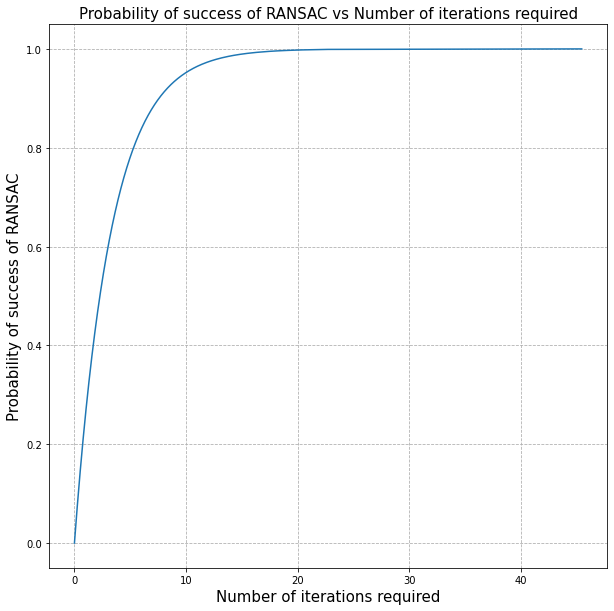

In [205]:
numOfIts(0.95, 0.2, 6)

plt.figure(figsize=(10, 10))
plt.axes()
x = np.linspace(0, 0.999999, 1000)
y = np.array([ numOfIts(i, 0.2, 6) for i in x ])
plt.plot(y, x)
plt.grid(linestyle='--')
plt.title('Probability of success of RANSAC vs Number of iterations required', fontsize=15)
plt.xlabel('Number of iterations required', fontsize=15)
plt.ylabel('Probability of success of RANSAC', fontsize=15)
plt.show()

**1.4** **BONUS:** Repeat the main experiment after correcting for radial distortion. Estimate the radial distortion parameters from the straight lines in the image. What do you observe regarding the resulting parameters?

**For this part you can use inbuilt cv2 functions.**

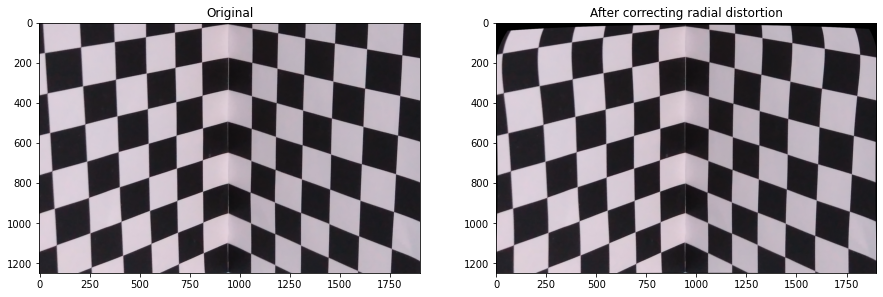

In [206]:
cb = cv2.imread('../calibration-data/calib-object.jpg')
cb = cb[1750:3000, 600:2500]
cv2.imwrite('newImg.jpg', cb)

# Coordinates
worldCoords = np.array([[28,0,0], [28*2,0,0], [28*3,0,0], [28*4,0,0], [28*5,0,0], [28,28,0], [28,28*2,0], [28,28*3,0], [28,28*4,0], [28,28*5,0], [28,28*6,0], [28,28*7,0]])
imageCoords = np.array([[1110,52], [1236,71], [1373,102], [1522,124], [1683,153], [1110,226], [1110,388], [1110,553], [1110,715], [1110,869], [1110,1025], [1110,1174]])

# Correcting radial distortion
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([worldCoords.astype('float32')], [imageCoords.astype('float32')], (cb.shape[1],cb.shape[0]), None, None)
undistortedcb = cv2.undistort(cb, mtx, dist)
cv2.imwrite('newImgUndistorted.jpg', undistortedcb)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
ax[0].imshow(cb)
ax[0].title.set_text('Original')
ax[1].imshow(undistortedcb)
ax[1].title.set_text('After correcting radial distortion')

In [207]:
P = DLT(worldCoords, imageCoords)
print("Projection before correcting radial distortion:\n")
print(P)
print('\nRMSE before correcting radial distortion:', findError(P, worldCoords, imageCoords))

Projection before correcting radial distortion:

[[-0.00000000e+00 -4.01064277e-32  8.47718100e-20 -1.09298479e-29]
 [-1.62443216e-32 -1.00343836e-31 -2.22044589e-16  3.55706273e-31]
 [ 3.95278009e-35 -2.89636104e-35  1.00000000e+00 -1.16498077e-32]]

RMSE before correcting radial distortion: 98.13174037271284


In [208]:
# Coordinates
worldCoords = np.array([[0,0,0], [28,0,0], [28,28,0], [28,56,0], [56,56,0], [84,84,0], [0,28,0], [0,56,0],[0,84,0],[0,0,28],[0,0,56],[0,28,28],[0,56,28],[0,84,56],[0,84,112],[0,140,0]])
imageCoords = np.array([[991,50], [1104,70], [1102,228], [1100,389], [1219,420], [1347,623], [988,205], [986,356], [983,508], [866,70], [739,87], [863,228], [863,383], [731,574], [456,655], [985,813]])

P = DLT(worldCoords, imageCoords)
print("Projection after correcting radial distortion:\n")
print(P)
print('\nRMSE after correcting radial distortion:', findError(P, worldCoords, imageCoords))

Projection after correcting radial distortion:

[[ 2.89389943e-03  1.75573772e-05 -5.26915858e-03  9.98741305e-01]
 [ 6.93029464e-04  5.56540026e-03  6.49348337e-04  4.94648472e-02]
 [-1.10191726e-06  6.90039222e-08 -9.95726949e-07  1.00986442e-03]]

RMSE after correcting radial distortion: 2.3649971149766325


**Observation:**

1) Image now looks undistorted.

2) Reonstruction error decreased after correcting radial distortion.

## **2. Zhang’s method**

**2.1** Use checkerboard images IMG5456.JPG - IMG5470.JPG and perform camera calibration using Zhang’s Method. **For this part you can use inbuilt cv2 functions.**

In [209]:
files = glob.glob('../calibration-data/IMG_*')

# World coordinates
x,y = np.meshgrid(range(6), range(8))
world = np.hstack((x.reshape(48, 1), y.reshape(48, 1), np.zeros((48, 1)))).astype('float32')

worldpts = []
imagePts = []
for filename in files:
  ret, corners = cv2.findChessboardCorners(cv2.imread(filename), (6, 8))
  if ret:
    imagePts.append(corners)
    worldpts.append(world)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(worldpts, imagePts, (5472, 3648), None, None)
print("Camera Matrix : \n\n", mtx, "\n")
print("Reprojection error : ", ret, "\n")

Camera Matrix : 

 [[1.36634814e+04 0.00000000e+00 3.33651179e+03]
 [0.00000000e+00 1.36813888e+04 1.49657922e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

Reprojection error :  2.4810222497142753 



**2.2** Using the estimated camera parameters compute the image points and overlay a wireframe over the actual image of chessboard using straight lines between the computed points. Refer to example-wireframe.png for reference. What do you observe about the overlay?

Note that do not use the image points found using the cv2.findChessboardCorners for wireframe overlay. Size of each square on checkerboard 29mmX29mm.

In [210]:
# Predict points
newPts = []
for i in range(len(worldpts)):
    pred, _ = cv2.projectPoints(worldpts[i], rvecs[i], tvecs[i], mtx, dist)
    newPts.append(pred)

newPts = np.array(newPts).reshape((-1, 2))

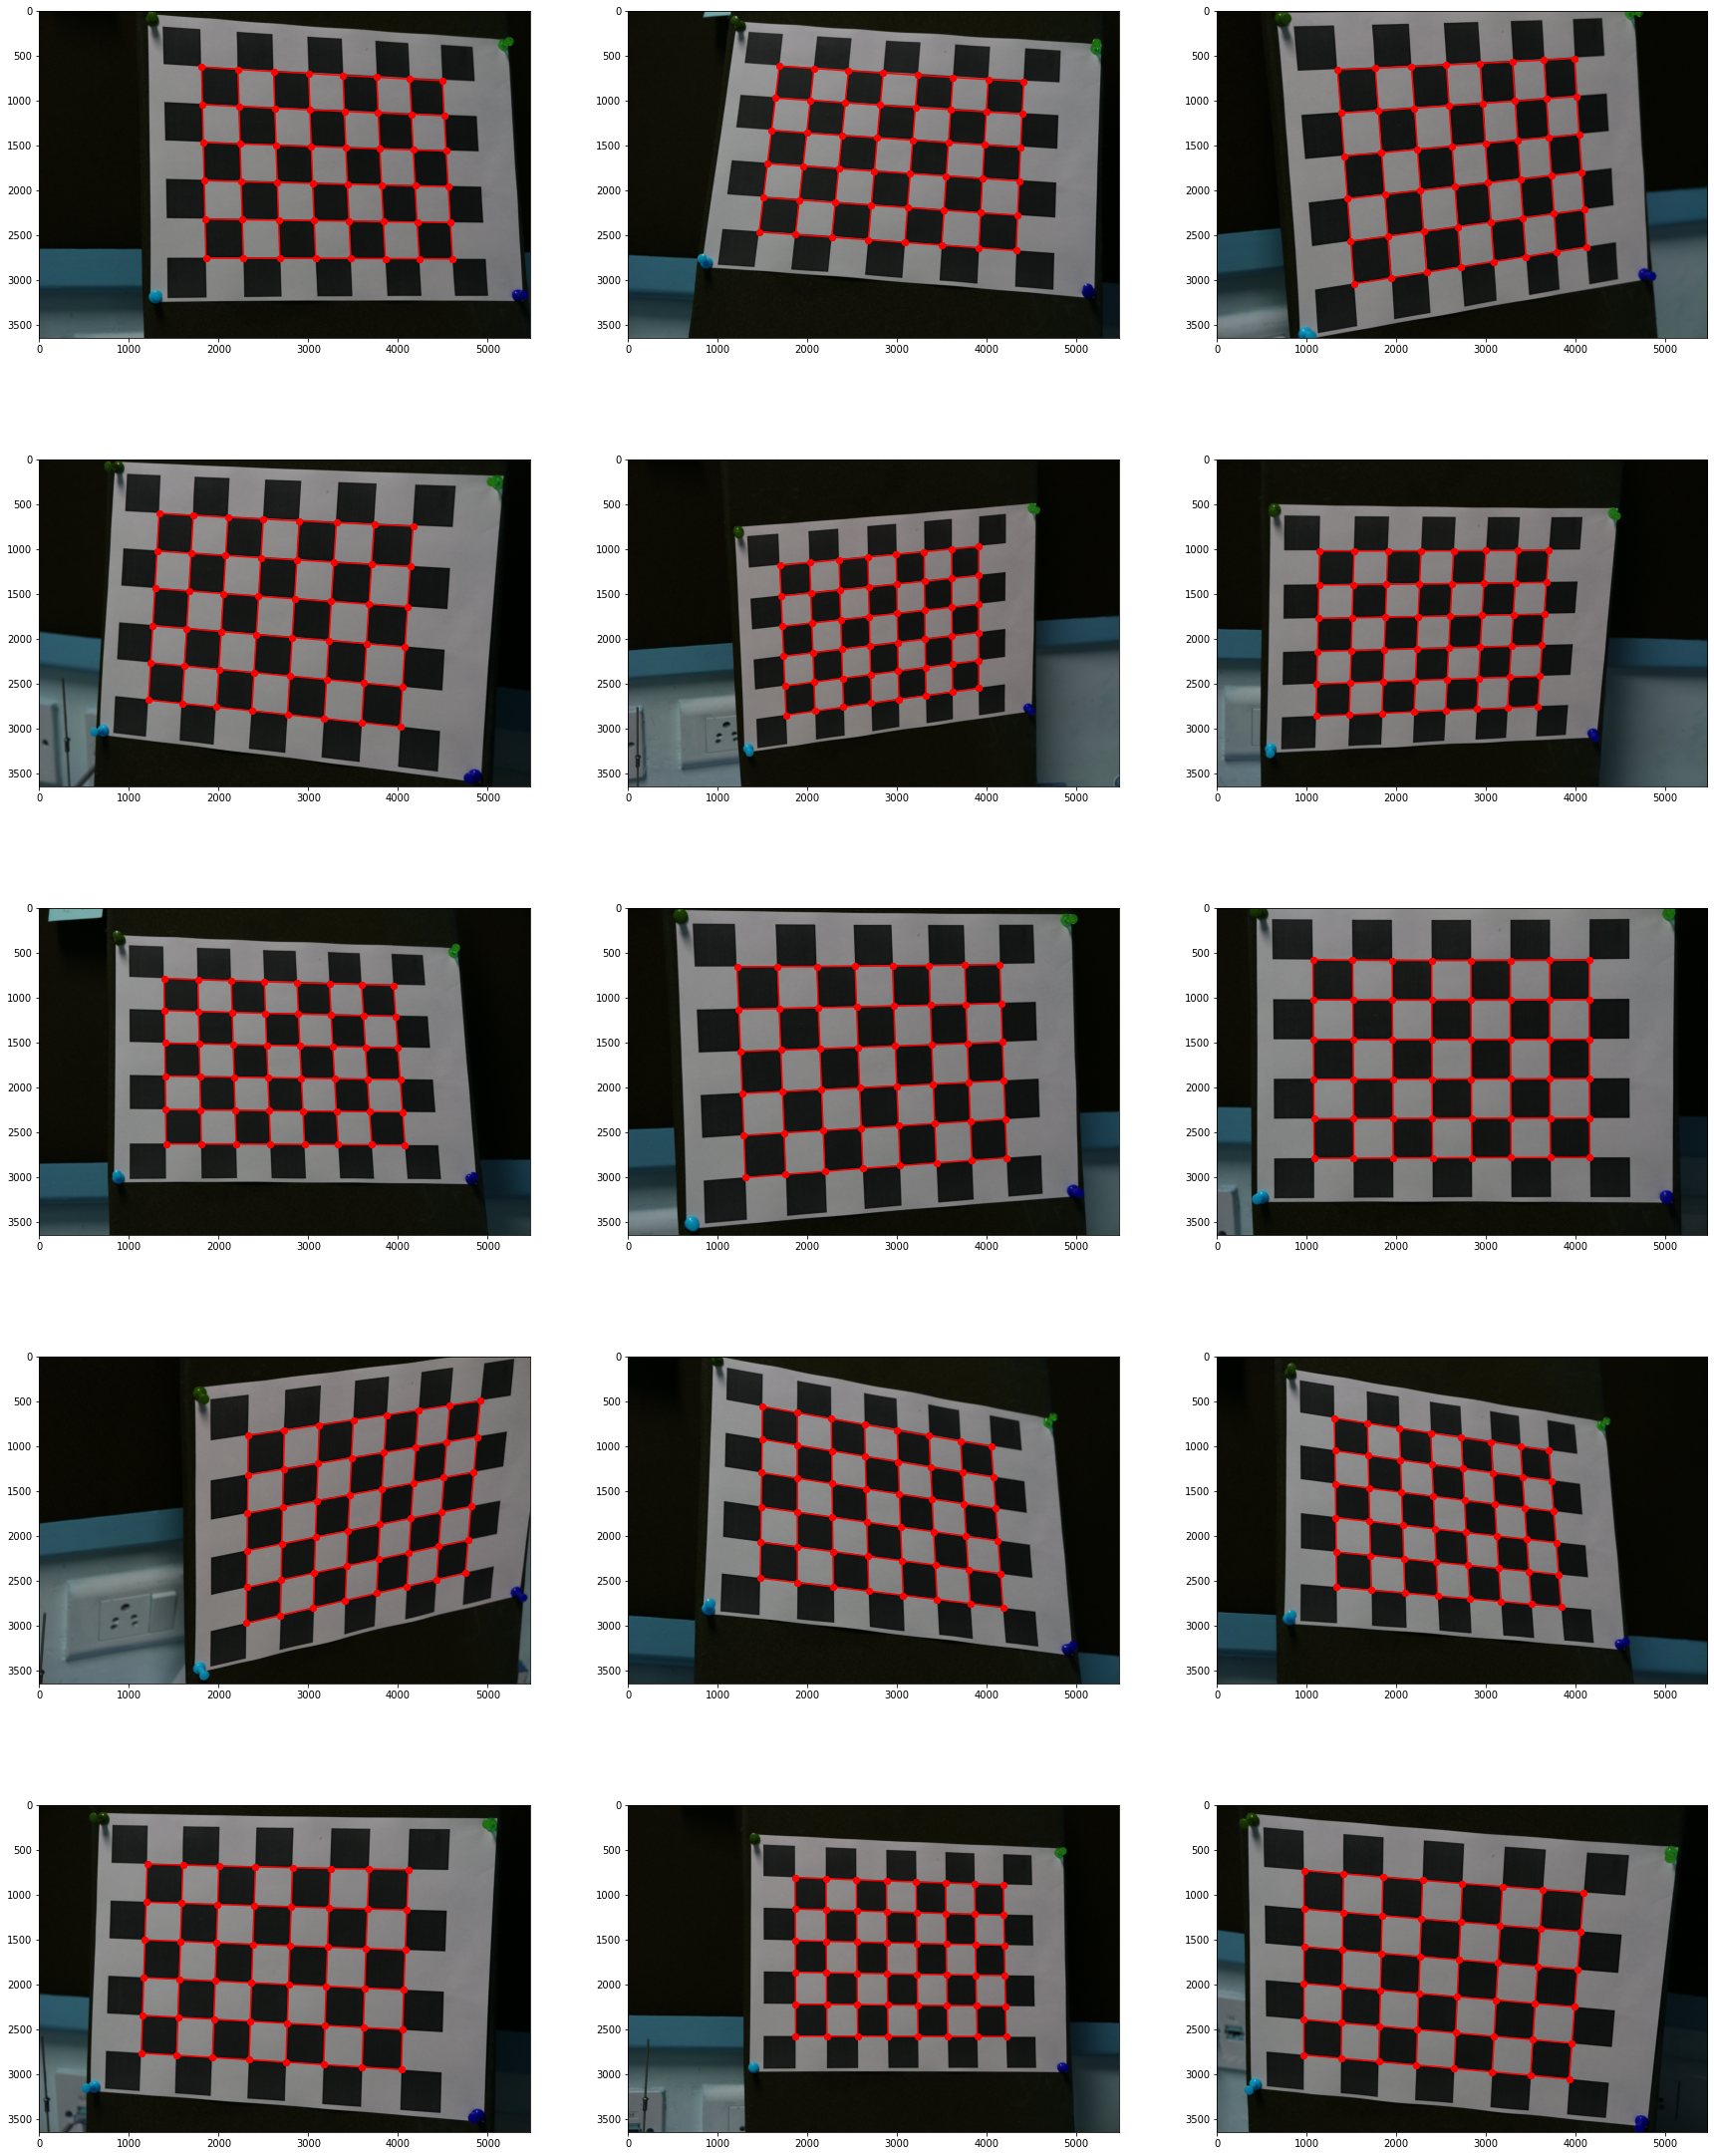

In [211]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(30, 40))

for i, filename in enumerate(files):
  img = cv2.imread(filename)

  # Making wireframe
  for j in range(8):
    plt.subplot(5, 3, i + 1).plot(newPts[i * 48 + j * 6:i * 48 + j * 6 + 6, 0], newPts[i * 48 + j * 6:i * 48 + j * 6 + 6, 1], 'ro-')
  for j in range(6):
    indices = np.arange(start=i * 48 + j, stop=(i + 1) * 48 + j, step=6)
    plt.subplot(5, 3, i + 1).plot(newPts[indices][:, 0], newPts[indices][:, 1], 'ro-')

  # Plotting
  plt.subplot(5, 3, i + 1).imshow(img)

warnings.resetwarnings()

**Observations:**

1) The points coincide with the corners of each checkerboard square.

2) The overlay wires coincide with the lines of the checkerboard.

## **3. DIY**
Perform the above DLT using the an image taken by your camera. Use a calibration
object for which you can measure the world co-ordinates.
Try the RANSAC based variant as well, for the same, and compare results.

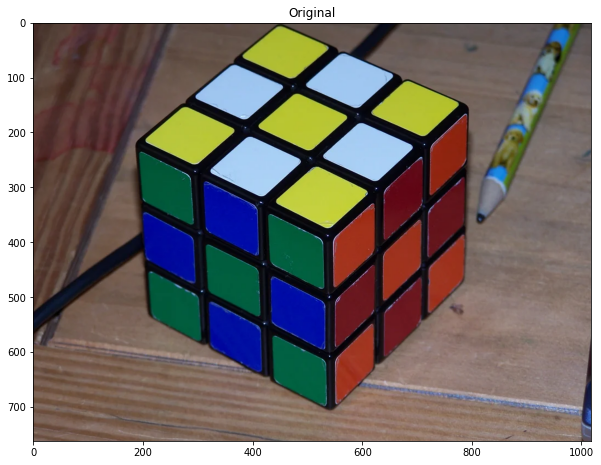

In [212]:
rubix = cv2.imread('../images/rubix.png', cv2.IMREAD_COLOR)
rubix = cv2.cvtColor(rubix, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (10, 10))
plt.title("Original")
plt.imshow(rubix)
plt.show()

In [213]:
# Coordinates
worldCoords = [[0, 0, 0], [1, 0, 0], [2, 0, 0], [3, 0, 0], [1, 0, 1], [2, 0, 2], [3, 0, 3], [0, 0, 1], [0, 0, 2], [0, 0, 3], [0, 1, 1], [0, 2, 2], [0, 3, 3], [0, 1, 0], [0, 2, 0], [0, 3, 0], [1, 1, 0], [2, 2, 0], [3, 3, 0]]
imageCoords = [[538, 389], [627, 309], [715, 227], [788, 155], [629, 425], [713, 446], [785, 468], [539, 500], [541, 607], [543, 702], [421, 441], [309, 493], [212, 532], [424, 334], [304, 274], [192, 222], [511, 247], [475, 115], [450, 0]]

worldCoords = np.array(worldCoords)
imageCoords = np.array(imageCoords)

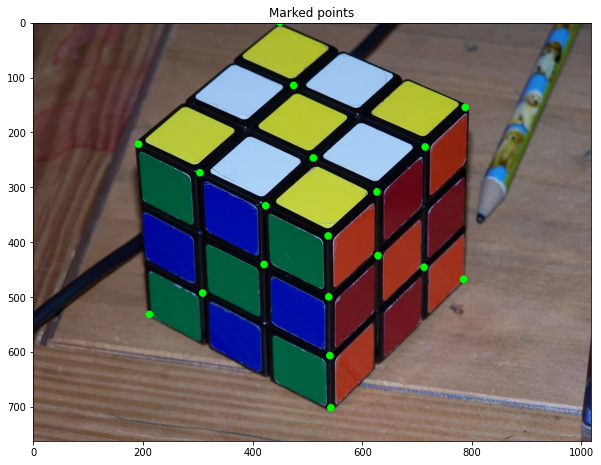

In [214]:
# Mark image coords on image
for i in imageCoords:
  rubix = cv2.circle(rubix, tuple(i), radius=7, color=(0, 255, 0), thickness=-1)

plt.figure(figsize = (10, 10))
plt.title("Marked points")
plt.imshow(rubix)
plt.show()

In [215]:
P = DLT(worldCoords, imageCoords)
print("Projection Matrix:\n")
print(P)
print('\nRMSE:', findError(P, worldCoords, imageCoords))

Projection Matrix:

[[-1.38413447e-01  1.62993405e-01 -1.60130891e-02 -7.71758822e-01]
 [ 1.10042917e-01  7.71224042e-02 -1.69868376e-01 -5.58114818e-01]
 [-2.17104463e-05 -1.95693756e-05 -2.66346459e-05 -1.42938989e-03]]

RMSE: 4.343296338254578


In [216]:
error, P = RANSAC(100, worldCoords, imageCoords)
print("Projection Matrix:\n")
print(P)
print('\nRMSE:', error)

Projection Matrix:

[[-1.46404593e-01  1.63883336e-01 -1.93211208e-02 -7.68873269e-01]
 [ 1.07112021e-01  7.91728039e-02 -1.73339187e-01 -5.58908481e-01]
 [-3.33414345e-05 -1.96876577e-05 -2.97171141e-05 -1.43304975e-03]]

RMSE: 5.491577363287555


**Observations:**

1) RANSAC gives a resonable error but is higher than that of DLT based reconstruction.

2) With more interations of RANSAC the error tends to become more closer to the error from DLT based reconstruction.